In [1]:
import pandas as pd
import time
import io
import datetime
import sys
pd.set_option('max_colwidth',150)
%matplotlib inline

### 1.Get the cleaned dataset 

In [2]:
df_abstract= pd.read_pickle('df_titleAbstract_supervised.pkl')
df_abstract.head(2)

Titre  \
0                       The basics of intravascular optical coherence tomography   
1  An eﬃcient orientation ﬁlter for inertial and inertial/magnetic sensor arrays   

                                                                                                                                                  Resume  \
0  Optical coherence tomography (OCT) has opened new horizons for intravascular coronary imaging. It utilizes near-infrared light to provide a micros...   
1  This report presents a novel orientation ﬁlter applicable to IMUs consisting of tri-axis gyroscopes and accelerometers, and MARG sensor arrays tha...   

                                                     URL  \
0  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4495121/   
1                                              #item_204   

                   Auteur                     Class  \
0          Roleder Tomasz           Active catheter   
1  Madgwick Sebastian O H  Multi Sensor Data Fusion   

                   ParentClass  \
0  Radiologie interventionelle   
1                           RI   

                                                                                                                                              BagOfWords  
0  basics coherence tomography coherence tomography oct horizons imaging provide microscopic pathology arteries coherence tomography composition plaq...  
1  orientation ﬁlter sensor arrays report presents orientation imus gyroscopes accelerometers sensor arrays magnetometers implementation incorporates...

In [3]:
df_abstract.shape

(391, 7)

In [4]:
len(df_abstract.ParentClass.unique())

11

In [5]:
len(df_abstract.Class.unique())

40

### 2. Encode the target 

In [6]:
from sklearn import preprocessing
#### Prepare the target and the numerique data
le = preprocessing.LabelEncoder()
df_abstract['Target']=le.fit_transform(df_abstract.ParentClass)
#df_abstract

### 3. Split the dataset into train & test, find BOW on train and transform test 

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
def splitDataFrame(df,label):
    split=StratifiedShuffleSplit(n_splits=1,test_size=0.3, random_state=42)
    for train_index, test_index in split.split(df,label):
        strat_train_set=df_abstract.iloc[train_index]
        strat_test_set=df_abstract.iloc[test_index]
    print(strat_train_set.shape,'\n')
    print(strat_test_set.shape,'\n')
    return strat_train_set,strat_test_set

In [8]:
train,test=splitDataFrame(df_abstract,df_abstract.Target)

(273, 8) 

(118, 8) 



###  Visualize the distribution of classes

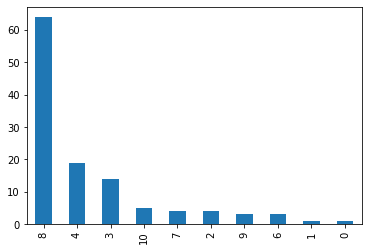

In [9]:
test.Target.value_counts().plot.bar()

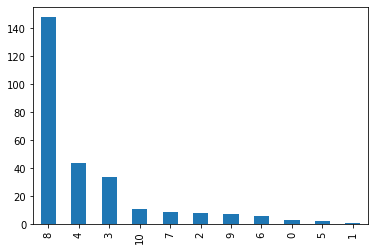

In [10]:
train.Target.value_counts().plot.bar()

### 4.  Convert the abstracts into a simple vector representation (Bag of Words BOW) by CountVectorizer, apply LDA to find the possible topics

In [11]:
import nltk
stop_uk = nltk.corpus.stopwords.words('english')
stop_uk.extend(['paper', 'none', 'image'])

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
# Load the LDA model from sk-learn
#vec = TfidfVectorizer(ngram_range=(2,2),stop_words = stop_uk,max_df=.8,max_features=300,min_df=10)
vec = TfidfVectorizer(ngram_range=(1,1),stop_words = stop_uk,max_df=.8,max_features=300,min_df=10)
X_train=vec.fit_transform(train.BagOfWords)
X_test=vec.transform(test.BagOfWords)

In [13]:
y_train=train['Target']
y_test=test['Target']

In [14]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(273, 214)
(118, 214)
(273,)
(118,)


In [15]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
# Build LDA Model
lda= LDA(n_components=20,               # Number of topics
                                      max_iter=10,               
# Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          
# Random state
                                      batch_size=128,            
# n docs in each learning iter
                                      evaluate_every = -1,       
# compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               
# Use all available CPUs
                                     )

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation as LDA
def gridSearchLDA(data_vectorized):
    # Define Search Param
    search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9],'batch_size':[128,150,200,250],'max_iter':[10,20,25,30,50]}
    # Init the Model
    lda = LDA(max_iter=5, learning_method='online', learning_offset=50.,random_state=0)
    # Init Grid Search Class
    model = GridSearchCV(lda, param_grid=search_params)
    # Do the Grid Search
    model.fit(data_vectorized)
    # Best Model
    best_lda_model = model.best_estimator_
    # Model Parameters
    print("Best Model's Params: ", model.best_params_)
    # Log Likelihood Score
    print("Best Log Likelihood Score: ", model.best_score_)
    return best_lda_model

In [17]:
ldaModel= gridSearchLDA(X_train)
#lda.components_

Best Model's Params:  {'batch_size': 128, 'learning_decay': 0.5, 'max_iter': 50, 'n_components': 10}
Best Log Likelihood Score:  -1824.2628633703353


In [18]:
X_train=ldaModel.transform(X_train)

In [19]:
X_test = ldaModel.transform(X_test)

In [20]:
print(X_train.shape)
print(X_test.shape)

(273, 10)
(118, 10)


In [21]:
#y_train.shape

In [22]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
def prepareDataForML(train,test):
    #y=le.fit_transform(df.Class)
    #print(y.shape)
    #### Split the data into train and test
    X_train=train.drop('Target',axis=1)._get_numeric_data()
    X_test=test.drop('Target',axis=1)._get_numeric_data()
    y_train=train.Target
    y_test=test.Target
    #X.shape
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    print(X_train.shape,'\n')
    print(X_test.shape,'\n')
    print(y_train.shape,'\n')
    print(y_test.shape,'\n')
    return X_train, X_test, y_train, y_test

In [23]:
from sklearn.preprocessing import StandardScaler
def normalizeTrainTest(X_train,X_test):
    # On change le format pour que scikitlearn tourne bien
    train_numpy = X_train.to_numpy()
    scaler=StandardScaler()
    # On centre réduit
    train_std = scaler.fit_transform(train_numpy)
    print(train_std.shape)
    # On change le format pour que scikitlearn tourne bien
    test_numpy = X_test.to_numpy()
    # On centre réduit
    test_std = scaler.transform(test_numpy)
    print(test_std.shape)
    return train_std,test_std

#### Split into train, test for the dataset and the target

In [24]:
#X_train, X_test, y_train, y_test=prepareDataForML(train,test)

In [25]:
#X_train

#### Normalize the train and test dataset

In [26]:
#train_std,test_std=normalizeTrainTest(X_train,X_test)

# ML 

## 1. RandomForest

In [27]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_absolute_error,mean_squared_error,roc_auc_score, roc_curve, auc

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
warnings.simplefilter(action='ignore')
%matplotlib inline

### Define the model of RandomForest

In [28]:
from sklearn.metrics import precision_recall_fscore_support as score
def EvaluateModel(model,X_test,y_test, y_predict):
    accuracy=accuracy_score(y_test, y_predict)
    #print('\n','\033[1m' + 'Accuracy score: '+'\033[0m',accuracy) # le plus important pour le moment; précisément la première ligne
    print('\n',classification_report(y_test, y_predict))
    precision,recall,fscore,support=score(y_test,y_predict)
    return precision,recall,fscore,accuracy

In [29]:
def MatrixConfusion(Model, X_test, y_test, y_predict):
    
    cm = confusion_matrix(y_test,y_pred)
    #Afficher la matrice de confusion avec heatmap 
    fig = plt.figure()
    ax = plt.subplot()
    mat = sns.heatmap(cm, annot=True, ax = ax ,fmt='g'); #annot=True to annotate cells
    ax.set_xlabel('Valeurs prédites');ax.set_ylabel('Valeurs réelles'); 
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    return mat

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold
def GridSearchRandomForest(X, y):
    
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(n_splits = 10, test_size = 0.3, random_state = 0)
    
    #cv_sets = StratifiedKFold(10,random_state = 0)
    
    #group=X['Pclass'].to_numpy()
    #cv_sets= list(GroupKFold( n_splits=3).split(X,y,group))
    
    # Create a decision tree classifier object
    classifier = RandomForestClassifier(random_state = 42)

    # Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    #params = {'max_depth':range(1, 20),'criterion': ['gini', 'entropy'],'max_features':range(1,17),'oob_score':[True,False],'min_samples_split':range(2,10),'max_leaf_nodes':range(5,15)}
    params = {'max_depth':range(1, 40),'criterion': ['gini', 'entropy']}

    # Create the grid search cv object --> GridSearchCV()
    # (estimator, param_grid, scoring, cv) which have values 'classifier','scoring', 'params', and 'cv_sets' respectively.
    grid = GridSearchCV(estimator=classifier, param_grid=params,scoring='accuracy', cv=cv_sets,n_jobs=-1)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

In [31]:
gridModel=GridSearchRandomForest(X_train,y_train)
gridModel

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [32]:
gridModel.score(X_train,y_train)

0.6923076923076923

In [33]:
y_pred = gridModel.predict(X_test)
# evaluate model
gridRF=EvaluateModel(gridModel,X_test,y_test, y_pred)


               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00        14
           4       0.47      1.00      0.64        19
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         4
           8       0.81      0.98      0.89        64
           9       0.00      0.00      0.00         3
          10       0.00      0.00      0.00         5

    accuracy                           0.69       118
   macro avg       0.13      0.20      0.15       118
weighted avg       0.51      0.69      0.58       118



Matrice de Confusion avec le modèle de RandomForest


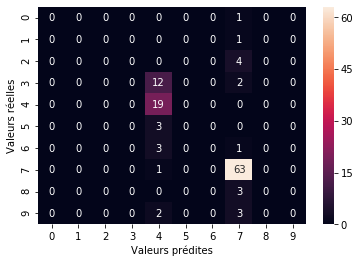

In [34]:
print("Matrice de Confusion avec le modèle de RandomForest")
gridRF=MatrixConfusion(gridModel,X_test,y_test, y_pred)

## 2. SVM 

In [35]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

#pca = PCA(n_components=4, svd_solver='randomized', whiten=True, random_state=42)
#svc = SVC(kernel='rbf', class_weight='balanced')
svc = SVC(kernel='rbf')
#model = make_pipeline(scale, svc)

In [36]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'C': [1, 5, 10, 50,60,80,90,100], # model__parametre
    'gamma': [0.0001, 0.0005, 0.001, 0.005,0.008,0.02,0.04,0.6]
}

grid = GridSearchCV(svc, param_grid,cv=ShuffleSplit(n_splits = 10, test_size = 0.3, random_state = 0))

%time grid.fit(X_train, y_train)
#print(grid.best_params_)

Wall time: 2 s


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.3, train_size=None),
             error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 5, 10, 50, 60, 80, 90, 100],
                         'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.008, 0.02,
                                   0.04, 0.6]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [37]:
model = grid.best_estimator_
model

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.04, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [38]:
model.score(X_train,y_train)

0.684981684981685

In [39]:
y_pred = model.predict(X_test)

In [40]:
# evaluate model
gridSVC=EvaluateModel(model,X_test,y_test, y_pred)


               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00        14
           4       0.46      1.00      0.63        19
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         4
           8       0.81      0.97      0.88        64
           9       0.00      0.00      0.00         3
          10       0.00      0.00      0.00         5

    accuracy                           0.69       118
   macro avg       0.13      0.20      0.15       118
weighted avg       0.51      0.69      0.58       118



In [41]:
print("Matrice de Confusion avec le modèle de SVC")
gridSVC=MatrixConfusion(model, X_test, y_test, y_pred)

Matrice de Confusion avec le modèle de SVC


## 3. LinearSVC

In [42]:
from sklearn.svm import LinearSVC
# Entraîner un classifieur linéaire (LinearSVC et SVC avec kernel='linear'. Quelle différence ?)
clf = LinearSVC(C=50,random_state=0,tol=1e-5)
clf.fit(X_train, y_train)

LinearSVC(C=50, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=0, tol=1e-05,
          verbose=0)

In [43]:
clf.score(X_train,y_train)

0.6996336996336996

In [44]:
# evaluate model
linearSVC=EvaluateModel(clf,X_test,y_test, y_pred)


               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00        14
           4       0.46      1.00      0.63        19
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         4
           8       0.81      0.97      0.88        64
           9       0.00      0.00      0.00         3
          10       0.00      0.00      0.00         5

    accuracy                           0.69       118
   macro avg       0.13      0.20      0.15       118
weighted avg       0.51      0.69      0.58       118



In [45]:
print("Matrice de Confusion avec le modèle de LinearSVC")
gridLinSVC=MatrixConfusion(clf, X_test, y_test, y_pred)

Matrice de Confusion avec le modèle de LinearSVC


# 4.Naives bayes

In [46]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB

skf = StratifiedKFold(n_splits=10)
params = {}
gnb = GaussianNB()
nb = MultinomialNB()
gs = GridSearchCV(gnb, cv=skf, param_grid=params, return_train_score=True)

gs.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             error_score=nan,
             estimator=GaussianNB(priors=None, var_smoothing=1e-09),
             iid='deprecated', n_jobs=None, param_grid={},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

In [47]:
y_pred = gs.fit(X_train,y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d"
       % (X_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 118 points : 105


In [48]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.11016949152542373


In [49]:
print("Matrice de Confusion avec le modèle de Naives Bayes")
matNaiBa=MatrixConfusion(gs,X_test,y_test, y_pred)

Matrice de Confusion avec le modèle de Naives Bayes


# 5.AdaBoost

In [50]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import StratifiedKFold

ada = AdaBoostClassifier(n_estimators=300, learning_rate=0.01)
ada.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.01,
                   n_estimators=300, random_state=None)

In [51]:
y_pred = ada.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy est', accuracy)
print('Rapport de classification Adaboost')
print('\n',classification_report(y_test, y_pred))

Accuracy est 0.6949152542372882
Rapport de classification Adaboost

               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         4
           3       0.40      0.57      0.47        14
           4       0.52      0.63      0.57        19
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         4
           8       0.83      0.97      0.89        64
           9       0.00      0.00      0.00         3
          10       0.00      0.00      0.00         5

    accuracy                           0.69       118
   macro avg       0.17      0.22      0.19       118
weighted avg       0.58      0.69      0.63       118



Matrice de Confusion avec le modèle de AdaBoost


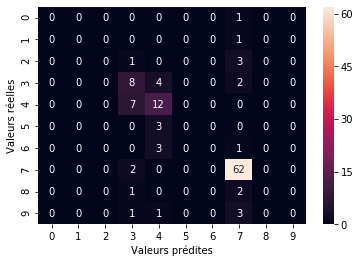

In [52]:
print("Matrice de Confusion avec le modèle de AdaBoost")
matAdB = MatrixConfusion(ada,X_test,y_test, y_pred)

# 6.ClusterCentroids

In [53]:
#Importations des librairies pour le rééchantillonnage
import numpy as np
from imblearn.metrics import classification_report_imbalanced
from sklearn.model_selection import GridSearchCV 
from sklearn.svm import SVC # "Support vector classifier"

Using TensorFlow backend.


In [54]:
param_grid = {
    'C': [1, 5, 10, 50,60,80,90,100], # model__parametre
    'gamma': [0.0001, 0.0005, 0.001, 0.005,0.008,0.02,0.04,0.6]
}

grid = GridSearchCV(svc, param_grid, cv=ShuffleSplit(n_splits = 10, test_size = 0.3, random_state = 0))


In [55]:
#Importation de la librarie
from imblearn.under_sampling import ClusterCentroids

# Sous-échantillonnage par calcul de centroïdes
cc = ClusterCentroids()
X_cc, y_cc = cc.fit_resample(X_train, y_train)

# Entraînement du modèle de SVM optimisé
grid.fit(X_cc, y_cc)

# Affichage des résultats
y_pred = grid.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy est', accuracy)

print('Rapport de classification avec la méthode de sous échantillonnage de clustering')
print(classification_report_imbalanced(y_test, y_pred))

Accuracy est 0.1016949152542373
Rapport de classification avec la méthode de sous échantillonnage de clustering
                   pre       rec       spe        f1       geo       iba       sup

          0       0.00      0.00      0.90      0.00      0.00      0.00         1
          1       0.00      0.00      0.57      0.00      0.00      0.00         1
          2       0.14      0.25      0.95      0.18      0.49      0.22         4
          3       0.40      0.29      0.94      0.33      0.52      0.25        14
          4       0.40      0.11      0.97      0.17      0.32      0.09        19
          5       0.00      0.00      0.97      0.00      0.00      0.00         0
          6       0.00      0.00      1.00      0.00      0.00      0.00         3
          7       0.13      0.75      0.82      0.22      0.79      0.61         4
          8       1.00      0.02      1.00      0.03      0.12      0.01        64
          9       0.00      0.00      0.98      0.00     

Matrice de Confusion avec le modèle de AdaBoost


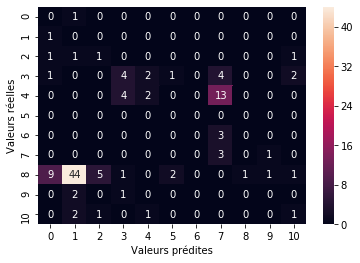

In [56]:
print("Matrice de Confusion avec le modèle de AdaBoost")
matAdB=MatrixConfusion(ada,X_test,y_test, y_pred)